# Testing Notebooks for Result Generations

## All Imports and Environment Settings

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (10,5)

if torch.cuda.is_available():
    device = torch.device('cuda')
# elif torch.backends.mps.is_available():
#   device = torch.device('mps')
else:
    device = torch.device('cpu')

print("Using device: {}".format(device))

data = pd.read_csv('sp500_index.csv', index_col='Date')
print(data)

Using device: cpu
             S&P500
Date               
2013-03-25  1551.69
2013-03-26  1563.77
2013-03-27  1562.85
2013-03-28  1569.19
2013-04-01  1562.17
...             ...
2023-03-20  3951.57
2023-03-21  4002.87
2023-03-22  3936.97
2023-03-23  3948.72
2023-03-24  3970.99

[2519 rows x 1 columns]


## Model Definition

In [2]:
class RNN(nn.Module):
    def __init__(self, hidden_dim=10, num_layers=1):
        super(RNN, self).__init__()
        self.input_dim = 1
        self.output_dim = 1
        self.num_layers = num_layers
        self.hidden_dim= hidden_dim
        self.rnn = nn.RNN(self.input_dim, hidden_dim, self.num_layers,batch_first=True)
        self.linear = nn.Linear(hidden_dim, self.output_dim)

    def forward(self, x):
        x.to(device)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, hn = self.rnn(x, h0)
        output = self.linear(out[:, -1, :])
        return output

In [3]:
class LSTM(nn.Module):
    def __init__(self,hidden_dim=10, num_layers=1):
        super(LSTM, self).__init__()
        self.input_dim = 1
        self.output_dim = 1
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, self.output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        x.to(device)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.linear(out[:, -1, :])
        return out

## Load model with state dictionaries

In [4]:
best_rnn = RNN(hidden_dim=50, num_layers=2)
best_lstm = LSTM(hidden_dim=20, num_layers=1)
best_rnn.load_state_dict(torch.load('best_rnn.pth'))
best_lstm.load_state_dict(torch.load('best_lstm.pth'))

<All keys matched successfully>

## Create dataset for generate predictions

In [5]:
def create_dataset(seq, window_size):
    x = []
    y = []
    for i in range(len(seq) - window_size):
        # windows are the training features
        window = seq[i : i+ window_size]
        # The RNN is many-to-many architecture, therefore the output size
        label = seq[i + window_size: i + window_size + 1]
        x.append(window)
        y.append(label)

    # Convert to numpy array for easier indexing
    x = np.array(x)
    y = np.array(y)

    # Split data into training and testing set
    train_size = int(0.8*len(seq))
    x_train, x_test = x[:train_size], x[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Convert to tensor
    x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
    x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
    y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
    y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)

    x_train = x_train.unsqueeze(2)
    x_test = x_test.unsqueeze(2)
    # return processed data
    return x_train, x_test, y_train, y_test

def create_testing_data(test_data, window_size):
    x = []
    y = []
    for i in range(len(test_data) - window_size):
        # windows are the training features
        window = test_data[i : i+ window_size]
        # The RNN is many-to-many architecture, therefore the output size
        label = test_data[i + window_size: i + window_size + 1]
        x.append(window)
        y.append(label)

    # Convert to numpy array for easier indexing
    x = np.array(x)
    y = np.array(y)
    x = torch.from_numpy(x).type(torch.Tensor)
    y = torch.from_numpy(y).type(torch.Tensor)
    x = x.unsqueeze(2)

    return x, y
scaler = MinMaxScaler(feature_range=(-1, 1))
data['S&P500'] = scaler.fit_transform(data['S&P500'].values.reshape(-1, 1))
x_train, x_test, y_train, y_test = create_dataset(data['S&P500'].values, 100)
testing_features, testing_target = create_testing_data(data['S&P500'].values, 100)

## Result Generation

Text(0.5, 1.0, 'Prediction over the whole time period')

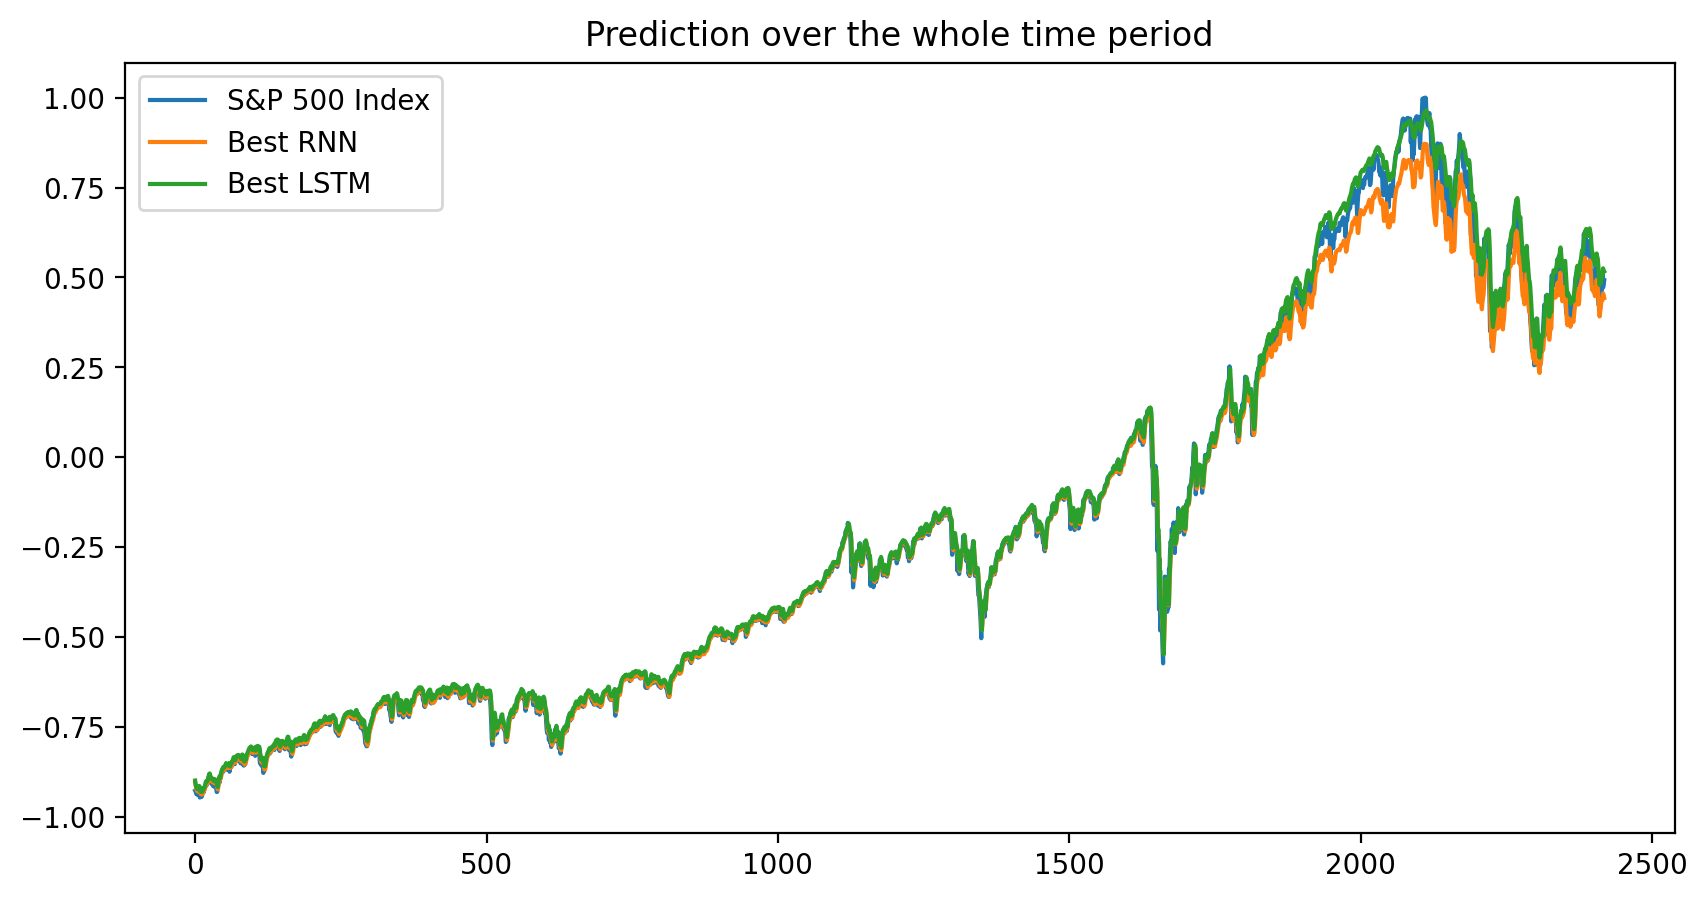

In [6]:
plt.plot(testing_target)
plt.plot(best_rnn(testing_features).detach().numpy())
plt.plot(best_lstm(testing_features).detach().numpy())
plt.legend(['S&P 500 Index','Best RNN', 'Best LSTM'])
plt.title('Prediction over the whole time period')

R2_score of LSTM: 0.9058336095648167
R2_score of RNN: 0.7863338300659095
LSTM Loss, MSE: 0.0032719229348003864, RMSE: 0.05720072612166405
RNN Loss, MSE: 0.0057362159714102745, RMSE: 0.07573781162500381


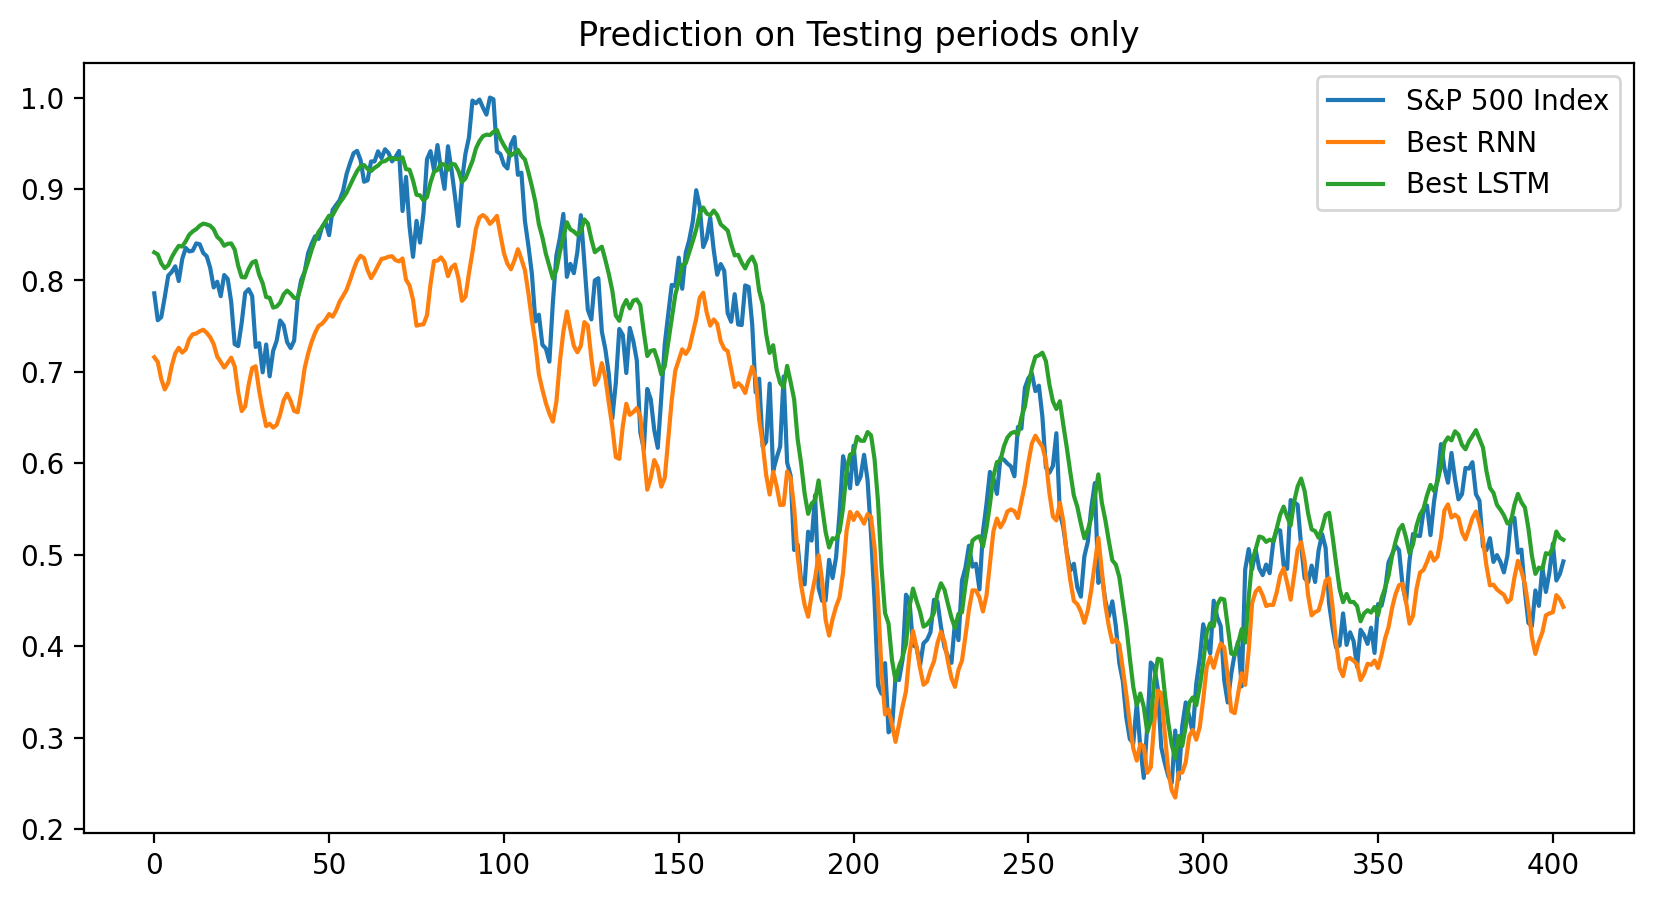

In [7]:
plt.plot(y_test)
plt.plot(best_rnn(x_test).detach().numpy())
plt.plot(best_lstm(x_test).detach().numpy())
plt.legend(['S&P 500 Index','Best RNN', 'Best LSTM'])
plt.title('Prediction on Testing periods only')
print("R2_score of LSTM: {}".format(r2_score(best_lstm(x_test).detach().numpy(), y_test.cpu().detach().numpy())))
print("R2_score of RNN: {}".format(r2_score(best_rnn(x_test).detach().numpy(), y_test.cpu().detach().numpy())))
mse_loss = nn.MSELoss()
print("LSTM Loss, MSE: {}, RMSE: {}".format(mse_loss(best_lstm(x_test), y_test).detach().numpy(),
                                            np.sqrt(mse_loss(best_lstm(x_test), y_test).detach().numpy())))
print("RNN Loss, MSE: {}, RMSE: {}".format(mse_loss(best_rnn(x_test), y_test).detach().numpy(),
                                           np.sqrt(mse_loss(best_rnn(x_test), y_test).detach().numpy())))

R2_score of LSTM: 0.9967478095013534
R2_score of RNN: 0.99421102766257
LSTM Loss, MSE: 0.0009282894898205996, RMSE: 0.030467843636870384
RNN Loss, MSE: 0.0014604945899918675, RMSE: 0.03821641951799393


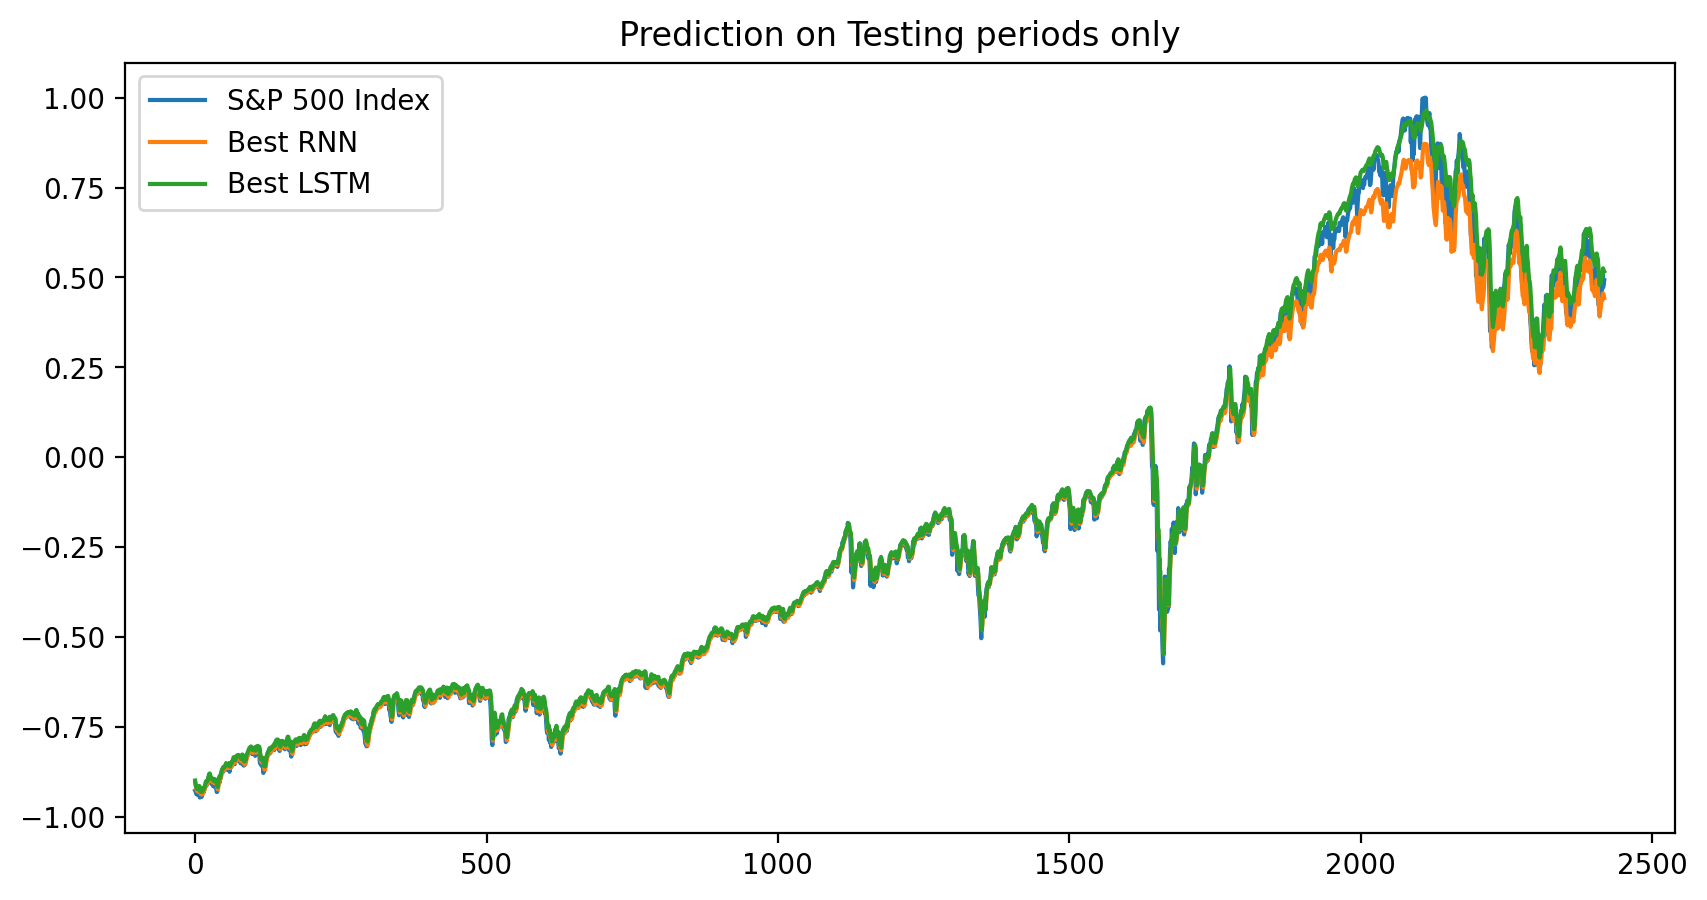

In [8]:
plt.plot(testing_target)
plt.plot(best_rnn(testing_features).detach().numpy())
plt.plot(best_lstm(testing_features).detach().numpy())
plt.legend(['S&P 500 Index','Best RNN', 'Best LSTM'])
plt.title('Prediction on Testing periods only')
print("R2_score of LSTM: {}".format(r2_score(best_lstm(testing_features).detach().numpy(), testing_target.cpu().detach().numpy())))
print("R2_score of RNN: {}".format(r2_score(best_rnn(testing_features).detach().numpy(), testing_target.cpu().detach().numpy())))
mse_loss = nn.MSELoss()
print("LSTM Loss, MSE: {}, RMSE: {}".format(mse_loss(best_lstm(testing_features), testing_target).detach().numpy(),
                                            np.sqrt(mse_loss(best_lstm(testing_features), testing_target).detach().numpy())))
print("RNN Loss, MSE: {}, RMSE: {}".format(mse_loss(best_rnn(testing_features), testing_target).detach().numpy(),
                                           np.sqrt(mse_loss(best_rnn(testing_features), testing_target).detach().numpy())))